### 1. Preprocessing

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Importing the dataset

#import breast-cancer-wisconsin.data
df = pd.read_csv('breast-cancer-wisconsin.data', header=None)

# Replace and drop bad values
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

#add column names
df.columns = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']

#drop sample code number
df.drop('Sample code number', axis=1, inplace=True)

#change target label
df['Class'] = df['Class'].map({2:0,4:1})


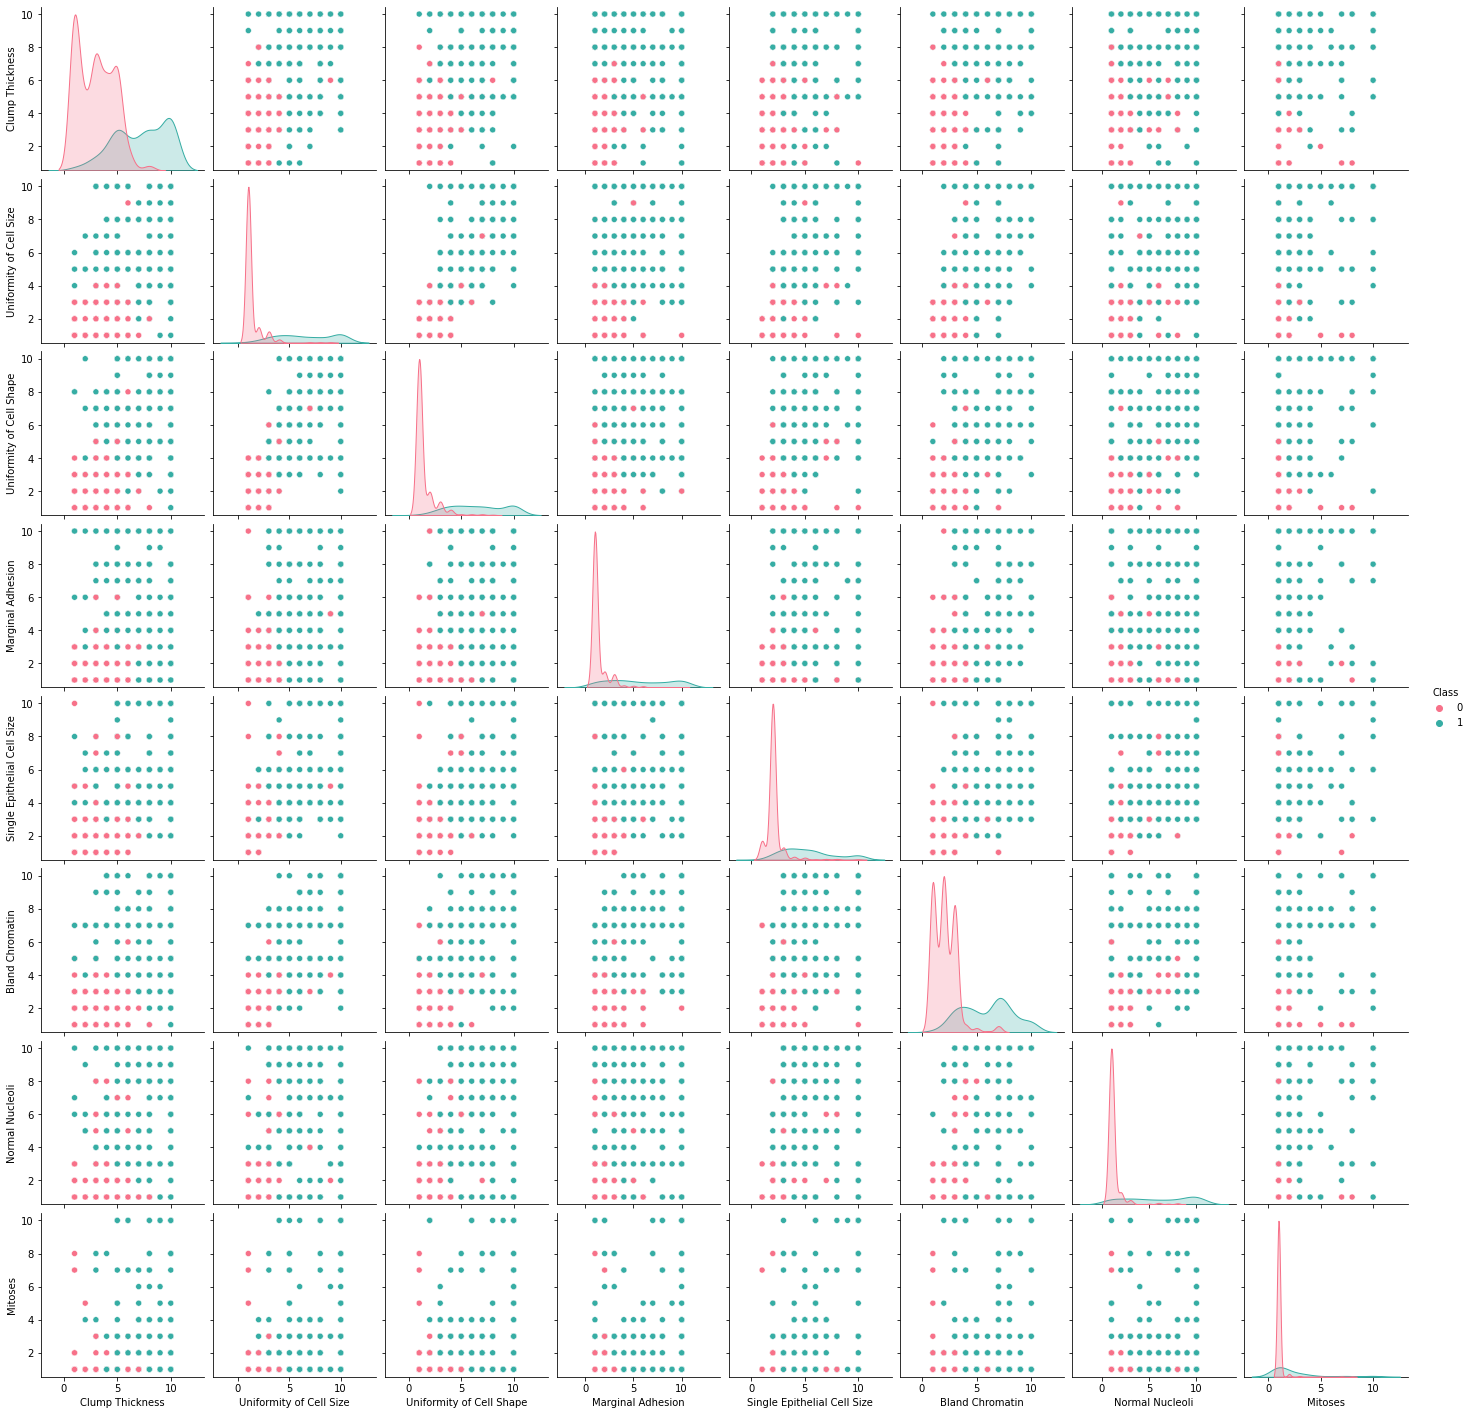

In [9]:
#create scatter plot matrix
sns.pairplot(df, hue='Class', diag_kind = 'kde', palette='husl')

In [10]:
#split data into training, validation and test sets
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)



In [11]:
# Fitting training SVM with linear kernel
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_val)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)

#calculate report
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.98      0.99        42

    accuracy                           0.99       110
   macro avg       0.99      0.99      0.99       110
weighted avg       0.99      0.99      0.99       110



In [13]:
# Fitting training SVM with rbf kernel
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_val)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)

#calculate report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        68
           1       1.00      0.98      0.99        42

    accuracy                           0.99       110
   macro avg       0.99      0.99      0.99       110
weighted avg       0.99      0.99      0.99       110



In [14]:
#fitting training SVM with polynomial kernel
classifier = SVC(kernel = 'poly', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_val)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)

#calculate report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        68
           1       1.00      0.88      0.94        42

    accuracy                           0.95       110
   macro avg       0.97      0.94      0.95       110
weighted avg       0.96      0.95      0.95       110



In [17]:
#perform cross fold validation on training set
from sklearn.model_selection import cross_val_score

#set classifier to linear
classifier = SVC(kernel = 'linear', random_state = 0)

accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))

#set classifier to rbf
classifier = SVC(kernel = 'rbf', random_state = 0)

accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))

#set classifier to polynomial
classifier = SVC(kernel = 'poly', random_state = 0)

accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

print("Accuracy: {:.2f} %".format(accuracies.mean()*100))


Accuracy: 96.33 %
Accuracy: 96.56 %
Accuracy: 95.18 %
